In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time
import random
import math

/home/mohammed/anaconda3/envs/scib_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [3]:
st = time.time()

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [5]:
url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
output = 'pbmc.h5ad'
gdown.download(url, output, quiet=False)

In [6]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [7]:
adata.X = adata.layers["counts"].copy()

In [8]:
condition_key = 'batch'
# cell_type_key = 'cell_type'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [9]:
# target_conditions = ["10X"]
removed_viallni = ['Villani']
chosen_source = ['Freytag']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(chosen_source)].copy()
# target_adata = adata[adata.obs.study.isin(target_conditions)].copy()
source_conditions = source_adata.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
source_adata, source_conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 3347 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Freytag'])

In [10]:
adata_tasks = adata_villani_removed
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list.remove('Freytag')
tasks_list.insert(0, 'Freytag')
tasks_list

['Freytag',
 'Oetjen_P',
 'Sun_sample2_KC',
 '10X',
 'Sun_sample4_TC',
 'Sun_sample1_CS',
 'Sun_sample3_TB',
 'Oetjen_U',
 'Oetjen_A']

In [11]:
source_adata.raw = source_adata

In [12]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [13]:
sc.pp.normalize_total(source_adata)

In [14]:
sc.pp.log1p(source_adata)

In [15]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [16]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [17]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [18]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [19]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='rehearsal',
)

rehearsal is happening!
 |████----------------| 23.2%  - val_loss: 427.3528544108 - val_recon_loss: 423.4018452962 - val_kl_loss: 6.8713237445 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████----------------| 24.6%  - val_loss: 427.9288431803 - val_recon_loss: 423.8051350911 - val_kl_loss: 6.7601731618 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 101


In [20]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

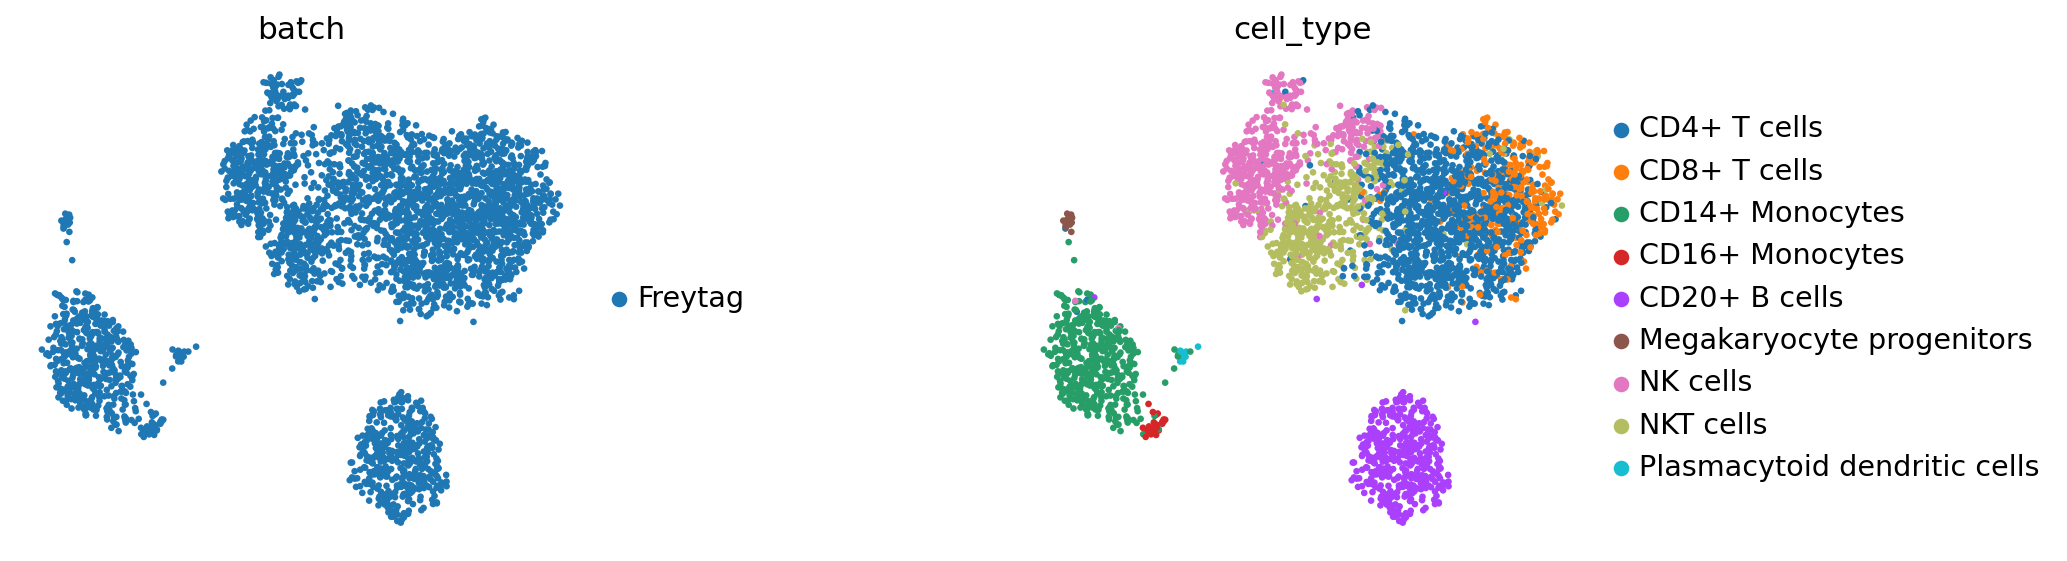

In [21]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [22]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [23]:
#It is only adding the new task!!!!!????
new_tasks = tasks_list
for ID in range(len(new_tasks)): #adata_tasks[1:] if you wanna skip the first item, , start=1
    print('ID:', ID)
    for i in range(ID):
        print('i:', i)
        ID_past = random.sample(new_tasks, 1)
        print(ID_past)
        task_i = adata_tasks[adata_tasks.obs['batch'].isin([str(ID_past),tasks_list[ID]])]
        print('adata_tasks[ID_past,ID]:', [ID_past,tasks_list[ID]])
        print('task_i:', task_i)
        new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                     learning_approach = 'rehearsal',
                                                     model=ref_path)
        new_trvae.train(
        n_epochs=surgery_epochs,
        alpha_epoch_anneal=200,
        early_stopping_kwargs=early_stopping_kwargs,
        #ID=ID,
        weight_decay=0,
        learning_approach = 'rehearsal'
        )

        ref_path = 'reference_model/'#+ str (ID)
        new_trvae.save(ref_path, overwrite=True)

ID BEFORE: 0
ID: 0
ID BEFORE: 1
ID: 1
i: 0
['Sun_sample3_TB']
adata_tasks[ID_past,ID]: [['Sun_sample3_TB'], 'Oetjen_P']
task_i: View of AnnData object with n_obs × n_vars = 3265 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3265 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 68
ID BEFORE: 2
ID: 2
i: 0
['Sun_sample3_TB']
adata_tasks[ID_past,ID]: [['Sun_sample3_TB'], 'Sun_sample2_KC']
task_i: View of AnnData object with n_obs × n_vars = 2281 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2281 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 188
i: 1
['Freytag']
adata_tasks[ID_past,ID]: [['Freytag'], 'Sun_sample2_KC']
task_i: View of AnnData object with n_obs × n_vars = 2281 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2281 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'c


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
ID BEFORE: 3
ID: 3
i: 0
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], '10X']
task_i: View of AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', '


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 58
i: 1
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], '10X']
task_i: View of AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'




Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 41
i: 2
['Oetjen_U']
adata_tasks[ID_past,ID]: [['Oetjen_U'], '10X']
task_i: View of AnnData object with n_obs × n_vars = 10727 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'




Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 8
ID BEFORE: 4
ID: 4
i: 0
['Sun_sample3_TB']
adata_tasks[ID_past,ID]: [['Sun_sample3_TB'], 'Sun_sample4_TC']
task_i: View of AnnData object with n_obs × n_vars = 2420 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2420 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', '


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 160
i: 1
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], 'Sun_sample4_TC']
task_i: View of AnnData object with n_obs × n_vars = 2420 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2420 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'



Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 85
i: 2
['Oetjen_U']
adata_tasks[ID_past,ID]: [['Oetjen_U'], 'Sun_sample4_TC']
task_i: View of AnnData object with n_obs × n_vars = 2420 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2420 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: '


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 3
['Sun_sample1_CS']
adata_tasks[ID_past,ID]: [['Sun_sample1_CS'], 'Sun_sample4_TC']
task_i: View of AnnData object with n_obs × n_vars = 2420 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2420 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
  


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
ID BEFORE: 5
ID: 5
i: 0
['10X']
adata_tasks[ID_past,ID]: [['10X'], 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 1725 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    l


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 28
i: 1
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 1725 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: '


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 18
i: 2
['Sun_sample2_KC']
adata_tasks[ID_past,ID]: [['Sun_sample2_KC'], 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 1725 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 29
i: 3
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 1725 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 25
i: 4
['Sun_sample2_KC']
adata_tasks[ID_past,ID]: [['Sun_sample2_KC'], 'Sun_sample1_CS']
task_i: View of AnnData object with n_obs × n_vars = 1725 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 1725 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 28
ID BEFORE: 6
ID: 6
i: 0
['Oetjen_P']
adata_tasks[ID_past,ID]: [['Oetjen_P'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'ti


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 126
i: 1
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'



Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 2
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'c


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 3
['Sun_sample2_KC']
adata_tasks[ID_past,ID]: [['Sun_sample2_KC'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
  


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 4
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
  


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 5
['Oetjen_P']
adata_tasks[ID_past,ID]: [['Oetjen_P'], 'Sun_sample3_TB']
task_i: View of AnnData object with n_obs × n_vars = 2403 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2403 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'c


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
ID BEFORE: 7
ID: 7
i: 0
['Oetjen_P']
adata_tasks[ID_past,ID]: [['Oetjen_P'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
 


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 175
i: 1
['Sun_sample1_CS']
adata_tasks[ID_past,ID]: [['Sun_sample1_CS'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    la


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 2
['Oetjen_U']
adata_tasks[ID_past,ID]: [['Oetjen_U'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 3
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 4
['Oetjen_P']
adata_tasks[ID_past,ID]: [['Oetjen_P'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 5
['Sun_sample1_CS']
adata_tasks[ID_past,ID]: [['Sun_sample1_CS'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    laye


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
i: 6
['Sun_sample3_TB']
adata_tasks[ID_past,ID]: [['Sun_sample3_TB'], 'Oetjen_U']
task_i: View of AnnData object with n_obs × n_vars = 3730 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    laye


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 0
ID BEFORE: 8
ID: 8
i: 0
['Sun_sample1_CS']
adata_tasks[ID_past,ID]: [['Sun_sample1_CS'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study'


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 60
i: 1
['10X']
adata_tasks[ID_past,ID]: [['10X'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIAL


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 68
i: 2
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 20
i: 3
['Oetjen_U']
adata_tasks[ID_past,ID]: [['Oetjen_U'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 17
i: 4
['Oetjen_U']
adata_tasks[ID_past,ID]: [['Oetjen_U'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 43
i: 5
['Oetjen_A']
adata_tasks[ID_past,ID]: [['Oetjen_A'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 19
i: 6
['Sun_sample4_TC']
adata_tasks[ID_past,ID]: [['Sun_sample4_TC'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    lay


Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 1
i: 7
['Freytag']
adata_tasks[ID_past,ID]: [['Freytag'], 'Oetjen_A']
task_i: View of AnnData object with n_obs × n_vars = 2586 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'
Query data contains expression data of  10303  genes that were not contained in the reference dataset. This information will be removed from the query data object for further processing.
AnnData object with n_obs × n_vars = 2586 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'



In [24]:
target_adata = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
target_adata

AnnData object with n_obs × n_vars = 29137 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [25]:
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 29137 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [26]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [27]:
full_latent = sc.AnnData(new_trvae.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

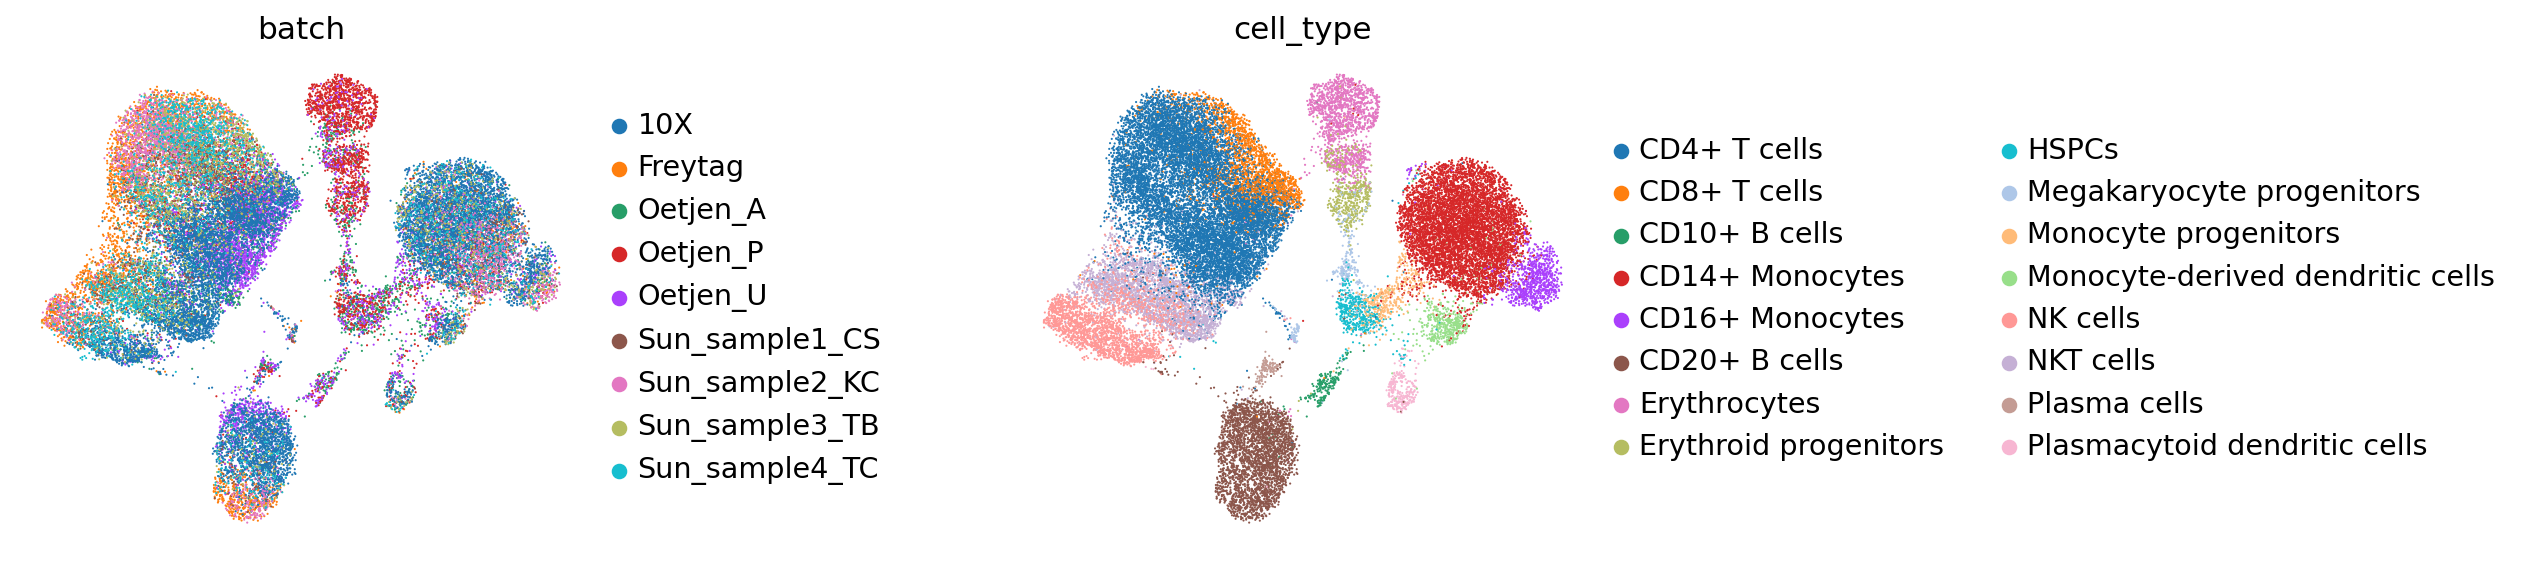

In [28]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [29]:
surg_path = 'model_PBMC_rehearsal'
new_trvae.save(surg_path, overwrite=True)

In [30]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:45:04


In [31]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_rehearsal=scib.metrics.graph_connectivity(full_latent, 'batch')

In [32]:
sc.tl.umap(full_latent)
Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_rehearsal

/tmp/ipykernel_129/4279557643.py:2: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Batch_corr_ASW_rehearsal=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.845275
CD14+ Monocytes                           0.866868
CD16+ Monocytes                           0.794350
CD20+ B cells                             0.781543
CD4+ T cells                              0.794625
CD8+ T cells                              0.780226
Erythrocytes                              0.731649
Erythroid progenitors                     0.804666
HSPCs                                     0.756465
Megakaryocyte progenitors                 0.713873
Monocyte progenitors                      0.730928
Monocyte-derived dendritic cells          0.727740
NK cells                                  0.717829
NKT cells                                 0.823014
Plasma cells                              0.527518
Plasmacytoid dendritic cells              0.632987


0.7518472871304152

In [33]:
Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_rehearsal

/tmp/ipykernel_129/403793534.py:1: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Bio_cons_ASW_rehearsal=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')


0.5862672179937363

In [34]:
isolated_labels_rehearsal=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_rehearsal

isolated labels: no more than 3 batches per label
Compute neighbors on rep X_umap
CD10+ B cells: 0.9242053789731051
Compute neighbors on rep X_umap
Erythrocytes: 0.8212485459480419
Compute neighbors on rep X_umap
Erythroid progenitors: 0.7999999999999999
Compute neighbors on rep X_umap
Monocyte progenitors: 0.5585023400936037


0.7759890662536877

In [35]:
pcr_justone=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_justone

0.6530575501015305